## Hybrid method: Recursive feature elimination

The approach consists of the following steps:

1) Rank the features according to their importance derived from a machine learning algorithm: it can be tree importance or  coefficients derived from linear models.

2) Remove one feature -the least important- and build a machine learning algorithm utilising the remaining features.

3) Calculate a performance metric of choice: roc-auc, mse, rmse, accuracy, etc.

4) If the metric decreases by more of an arbitrarily set threshold, then that feature is important and should be kept. Otherwise, we can remove that feature.

5) Repeat steps 2-4 until all features have been evaluated.


I call this a hybrid method because:

- it derives the importance derived from the machine learning algorithm, like embedded methods
- it builds several machine learning models, like wrapper methods.

This method is faster than wrapper methods and often better than embedded methods. In practice it works extremely well. 

One thing to note is that the minimum drop in performance to decide if a feature should be kept is set arbitrarily. The smaller the drop the more features will be selected, and vice versa.

I will demonstrate how to select features using this method on a regression and classification problem.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score

## Classification

In [2]:
# load dataset
data = pd.read_csv('dataset_1.csv')
data.shape

(50000, 301)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,...,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0


**Important**

In all feature selection procedures, it is good practice to select the features by examining only the training set. And this is to avoid overfit.

In [4]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 300), (15000, 300))

### Remove constant and quasi-constant features

In [5]:
# to speed things up we remove constant, quasi-constand and duplicated features

quasi_constant_feat = []

# iterate over every feature
for feature in X_train.columns:

    # find the predominant value, that is the value that is shared
    # by most observations
    predominant = (X_train[feature].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the predominant feature: do more than 99% of the observations
    # show 1 value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(feature)

X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 158), (15000, 158))

### Remove duplicated features

In [6]:
duplicated_feat = []
for i in range(0, len(X_train.columns)):
    if i % 10 == 0:  # this helps me understand how the loop is going
        print(i)

    col_1 = X_train.columns[i]

    for col_2 in X_train.columns[i + 1:]:
        if X_train[col_1].equals(X_train[col_2]):
            duplicated_feat.append(col_2)
            
len(duplicated_feat)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150


6

In [7]:
# remove duplicated features
X_train.drop(labels=duplicated_feat, axis=1, inplace=True)
X_test.drop(labels=duplicated_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((35000, 152), (15000, 152))

### Build ML model with all features

In [8]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# build initial model using all the features
model_full = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# calculate the roc-auc in the test set
y_pred_test = model_full.predict_proba(X_test)[:, 1]
roc_full = roc_auc_score(y_test, y_pred_test)

print('Test ROC AUC=%f' % (roc_full))

Test ROC AUC=0.827532


### Rank features by importance

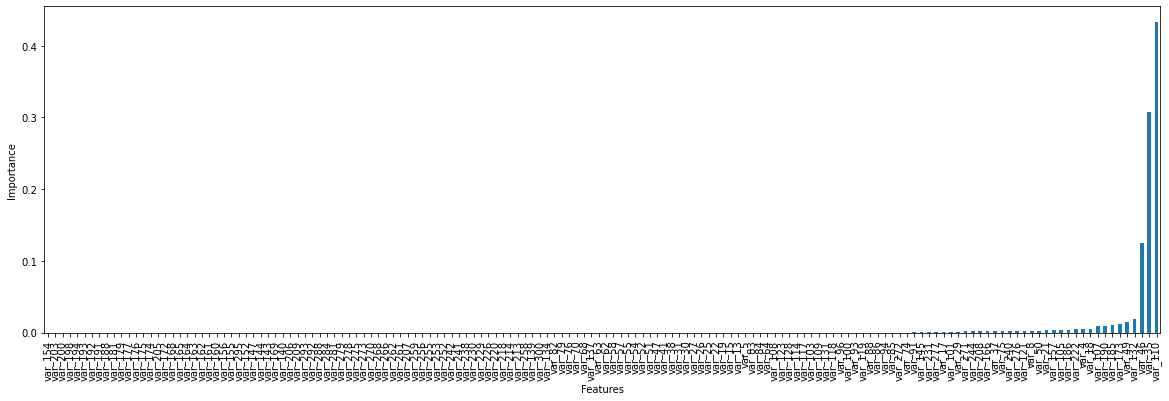

In [9]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [10]:
# make list of ordered features
features = list(features.index)
features

['var_154',
 'var_203',
 'var_200',
 'var_198',
 'var_194',
 'var_193',
 'var_192',
 'var_191',
 'var_188',
 'var_181',
 'var_179',
 'var_177',
 'var_176',
 'var_175',
 'var_174',
 'var_205',
 'var_172',
 'var_168',
 'var_165',
 'var_164',
 'var_163',
 'var_162',
 'var_161',
 'var_160',
 'var_156',
 'var_155',
 'var_295',
 'var_152',
 'var_147',
 'var_144',
 'var_143',
 'var_169',
 'var_140',
 'var_206',
 'var_209',
 'var_293',
 'var_292',
 'var_288',
 'var_284',
 'var_281',
 'var_279',
 'var_278',
 'var_275',
 'var_273',
 'var_270',
 'var_268',
 'var_266',
 'var_262',
 'var_261',
 'var_207',
 'var_259',
 'var_256',
 'var_255',
 'var_253',
 'var_252',
 'var_242',
 'var_241',
 'var_238',
 'var_230',
 'var_229',
 'var_226',
 'var_220',
 'var_218',
 'var_214',
 'var_213',
 'var_258',
 'var_139',
 'var_300',
 'var_134',
 'var_82',
 'var_79',
 'var_76',
 'var_70',
 'var_68',
 'var_137',
 'var_63',
 'var_62',
 'var_58',
 'var_57',
 'var_55',
 'var_54',
 'var_52',
 'var_51',
 'var_47',
 'var_

### Select features

In [ ]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build an model at each round.

# once we build the model, we calculate the new roc-auc

# if the new roc-auc is smaller than the original one
# (with all the features), then the feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in roc-auc
# if the drop is below this threshold,
# the feature will be removed
tol = 0.0005

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know where the loop is
count = 1

# now we loop over all the features, in order of importance:
# remember that features is this list are ordered
# by importance
for feature in features:
    
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

    # fit model with all variables, minus the feature to be evaluated
    # and also minus all features that were deemed to be removed
    
    # note that features_to_remove will be empty in the first rounds
    # but will have features as the loop proceeds
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction using the test set
    y_pred_test = model_int.predict_proba(
        X_test.drop(features_to_remove + [feature], axis=1))[:, 1]

    # calculate the new roc-auc
    roc_int = roc_auc_score(y_test, y_pred_test)
    print('New Test ROC AUC={}'.format((roc_int)))

    # print the original roc-auc with all the features
    print('Full dataset ROC AUC={}'.format((roc_full)))

    # determine the drop in the roc-auc
    diff_roc = roc_full - roc_int

    # compare the drop in roc-auc with the tolerance
    # we set previously
    if diff_roc >= tol:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('keep: ', feature)
        print
    else:
        print('Drop in ROC AUC={}'.format(diff_roc))
        print('remove: ', feature)
        print
        # if the drop in the roc is small and we remove the
        # feature, we need to set the new roc to the one based on
        # the remaining features
        roc_full = roc_int
        
        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

# The simulation will take a while!

doing recursive feature elimination

testing feature:  var_154 1  out of  152
New Test ROC AUC=0.8275385663137131
Full dataset ROC AUC=0.8275318972167823
Drop in ROC AUC=-6.669096930811413e-06
remove:  var_154

testing feature:  var_203 2  out of  152
New Test ROC AUC=0.8276405243718757
Full dataset ROC AUC=0.8275385663137131
Drop in ROC AUC=-0.00010195805816259895
remove:  var_203

testing feature:  var_200 3  out of  152
New Test ROC AUC=0.8274994560164579
Full dataset ROC AUC=0.8276405243718757
Drop in ROC AUC=0.00014106835541782825
remove:  var_200

testing feature:  var_198 4  out of  152
New Test ROC AUC=0.8275510002232452
Full dataset ROC AUC=0.8274994560164579
Drop in ROC AUC=-5.1544206787323965e-05
remove:  var_198

testing feature:  var_194 5  out of  152
New Test ROC AUC=0.8275221761602394
Full dataset ROC AUC=0.8275510002232452
Drop in ROC AUC=2.8824063005861156e-05
remove:  var_194

testing feature:  var_193 6  out of  152
New Test ROC AUC=0.8275526957563633
Full dataset R

In [ ]:
# now for comparison, we build a model with the selected features only

model_final = GradientBoostingClassifier(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict_proba(X_test[features_to_keep])[:, 1]

# calculate roc-auc
roc_final = roc_auc_score(y_test, y_pred_test)
print('Test selected features ROC AUC=%f' % (roc_final))

**As you can see, the Gradient Boosting model built with 12 features shows a similar performance than the one built the full dataset (you need to scroll up to find this value, we calculated a few cells ago).**


## Regression

In [ ]:
# load dataset

data = pd.read_csv('houseprice.csv')
data.shape

In [ ]:
# In practice, feature selection should be done after data pre-processing,
# so ideally, all the categorical variables are encoded into numbers,
# and then you can assess how deterministic they are of the target

# here for simplicity I will use only numerical variables
# select numerical columns:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

In [ ]:
# separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

In [ ]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Build ML model with all features

In [ ]:
# the first step of this procedure consists in building
# a machine learning algorithm using all the available features
# and then determine the importance of the features according
# to the algorithm

# build initial model using all the features
model_full = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

model_full.fit(X_train, y_train)

# calculate r2 in the test set
y_pred_test = model_full.predict(X_test)
r2_full = r2_score(y_test, y_pred_test)

print('Test full dataset R2 = %f' % (r2_full))

### Rank features by importance

In [ ]:
# the second step consist of deriving the importance of 
# each feature and ranking them from the least to the most
# important

# get feature name and importance
features = pd.Series(model_full.feature_importances_)
features.index = X_train.columns

# sort the features by importance
features.sort_values(ascending=True, inplace=True)

# plot
features.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
# make list with ordered features
features = list(features.index)
features

### Select features

In [ ]:
# the final step consists in removing one at a time
# all the features, from the least to the most
# important, and build model at each round.

# once we build the model, we calculate the new r2
# if the new r2 is smaller than the original one
# (with all the features), then that feature that was removed
# was important, and we should keep it.
# otherwise, we should remove the feature

# recursive feature elimination:

# first we arbitrarily set the drop in r2
# if the drop is below this threshold,
# the feature will be removed
tol = 0.001

print('doing recursive feature elimination')

# we initialise a list where we will collect the
# features we should remove
features_to_remove = []

# set a counter to know which feature is being evaluated
count = 1

# now we loop over all the features, in order of importance:
# remember that features in the list are ordered
# by importance
for feature in features:
    print()
    print('testing feature: ', feature, count, ' out of ', len(features))
    count = count + 1

    # initialise model
    model_int = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

    # fit model with all variables minus the removed features
    # and the feature to be evaluated
    model_int.fit(
        X_train.drop(features_to_remove + [feature], axis=1), y_train)

    # make a prediction over the test set
    y_pred_test = model_int.predict(
        X_test.drop(features_to_remove + [feature], axis=1))

    # calculate the new r2
    r2_int = r2_score(y_test, y_pred_test)
    print('New Test r2 = {}'.format((r2_int)))

    # print the original r2 with all the features
    print('All features Test r2 = {}'.format((r2_full)))

    # determine the drop in the r2
    diff_r2 = r2_full - r2_int

    # compare the drop in r2 with the tolerance
    # we set previously
    if diff_r2 >= tol:
        print('Drop in r2 ={}'.format(diff_r2))
        print('keep: ', feature)
        print
    else:
        print('Drop in r2 = {}'.format(diff_r2))
        print('remove: ', feature)
        print
        # if the drop in the r2 is small and we remove the
        # feature, we need to set the new r2 to the one based on
        # the remaining features
        r2_full = r2_int
        
        # and append the feature to remove to the collecting list
        features_to_remove.append(feature)

# now the loop is finished, we evaluated all the features
print('DONE!!')
print('total features to remove: ', len(features_to_remove))

# determine the features to keep (those we won't remove)
features_to_keep = [x for x in features if x not in features_to_remove]
print('total features to keep: ', len(features_to_keep))

In [ ]:
# finally let's test the performance of the model 
# built on the selected features

# build initial model
model_final = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)

# fit the model with the selected features
model_final.fit(X_train[features_to_keep], y_train)

# make predictions
y_pred_test = model_final.predict(X_test[features_to_keep])

# calculate roc-auc
r2_final = r2_score(y_test, y_pred_test)
print('Test selected features r2 = %f' % (r2_final))

The model built with 28 features shows similar or slightly better performance! (you need to scroll up to find this value, we calculated a few cells ago).